<a href="https://colab.research.google.com/github/naoya1110/DL_Lecture_202107/blob/main/Chapter12_UdonAI_Grad_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 12: UdonAI Grad-CAM
深層学習モデルを用いて画像分類を行う場合，そのモデルが入力画像のどの部分に着目して判断したのかを可視化するために[Grad-CAM](https://keras.io/examples/vision/grad_cam/)という手法が知られています。ここではChapter11までに開発したUdonAIの学習済みモデルに対してGrad-CAMを適用してみましょう。

## パッケージのインポート

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=3,  suppress=True)
import cv2

import tensorflow as tf
from tensorflow.keras.models import load_model, Model
# TensorFlowのバージョンを確認
print("TensorFlow version: " + tf.__version__)

TensorFlow version: 2.5.0


## うどん店の名前を定義

In [2]:
udonya_dict = {
                        0 : "nagata-in-kanoka",
                        1 : "udon-bakaichidai",
                        2 : "yamagoe",
                        3 : "gamou",
                        4 : "hinode-seimenjo",
                        5 : "ippuku",
                        6 : "moriya",
                        7 : "yoshiya",
                        8 : "sakaeda",
                        9 : "yamadaya"
                        }
                        
udonya_labels = udonya_dict.values()
udonya_labels

dict_values(['nagata-in-kanoka', 'udon-bakaichidai', 'yamagoe', 'gamou', 'hinode-seimenjo', 'ippuku', 'moriya', 'yoshiya', 'sakaeda', 'yamadaya'])

## Googleドライブのマウント

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


googleドライブ内の`DL_Lecture_202107`ディレクトリを作業ディレクトリ`working_dir`として設定します。

In [4]:
working_dir = "/content/drive/MyDrive/DL_Lecture_202107"

## データの読み込み
Chapter07で作成したデータセット`udon10_dataset.npz`を読み込みます。ここではモデルの学習に使用されておらず，正解が分かっている検証用データ（validX, validY）のみを使用します。

In [5]:
dataset_name = "udon10_dataset.npz"
dataset_path = os.path.join(working_dir, dataset_name)

data = np.load(dataset_path)    # dataset_pathからnumpy形式のバイナリデータを取得

validX = data["validX"]
validY = data["validY"]

## モデルの読み込み
Chapter11で学習させたモデル`UdonAI_best_vgg16_model.h5`を読み込みます。

In [6]:
model_path = os.path.join(working_dir, "UdonAI_best_vgg16_model.h5")    # model_pathの作成
model = load_model(model_path)    # モデルの読み込み

model.summary()    # モデルの概要を表示

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input layer (InputLayer)     [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

## 画像のサイズと最終畳み込み層の名前を確認
学習済みモデルの入力画像のサイズと最終畳み込み層の名前をそれぞれ`image_size`, `last_conv_layer_name`に入れておきます。

In [7]:
img_size = (128, 128)
last_conv_layer_name = "block5_conv3"

## 推論
`validX`から1枚の画像を選択し，学習済みモデルに入力します。

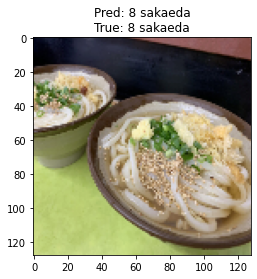

In [14]:
i = 0                             # i番目を指定
img = validX[i].astype("float32") # validXからi番目の画像を選択
true_index = validY[i]            # validYからi番目の値を選択

input_tensor = np.expand_dims(img, axis=0)    # モデルに入力できるように画像データの次元を拡張
pred = model.predict(input_tensor)[0]         # 推論
pred_index = np.argmax(pred)                  # 推論結果から確率の最も高い店舗のindexを取得

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    # 色変換 BGR ---> RGB
img = (255*img).astype("uint8")               # データ型変更 float ---> int

title = f"Pred: {pred_index} {udonya_dict[pred_index]}\nTrue: {true_index} {udonya_dict[true_index]}"
plt.title(title)   # 推論結果をタイトルとして表示
plt.imshow(img)    # 画像を表示

## `make_gradcam_heatmap()`の定義
Grad-CAMを使ってヒートマップを生成する関数`make_gradcam_heatmap()`を定義します。

詳しくはこのサイトを確認してください。
https://keras.io/examples/vision/grad_cam/

In [16]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

## ヒートマップの生成
`make_gradcam_heatmap()`を使ってヒートマップを生成します。使用した学習モデルは赤い部分に注目して判断したことを示しています。

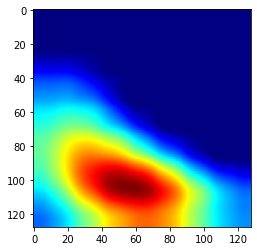

In [17]:
# heatmapの生成
heatmap = make_gradcam_heatmap(img_array=input_tensor,
                               model=model, 
                               last_conv_layer_name=last_conv_layer_name,
                               pred_index=pred_index)

# heatmapの可視化
heatmap = (255*heatmap).astype("uint8")                                                     # データ型変更 float ---> int
heatmap = cv2.resize(heatmap, img_size, interpolation = cv2.INTER_CUBIC)    # リサイズ
heatmap_jet = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)                   # 色変換 grayscale ---> jet
heatmap_jet = cv2.cvtColor(heatmap_jet, cv2.COLOR_BGR2RGB)                    # 色変換 BGR ---> RGB
plt.imshow(heatmap_jet)                                                                              # heatmap_jetの表示

## 元画像とヒートマップの合成
元画像とヒートマップを重ね合わせることでどの部分に注目しているのかより分かりやすく可視化します。

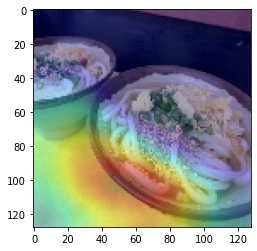

In [18]:
alpha = 0.5                                                                                    # heatmapの強さ
superimposed_img = img + alpha*heatmap_jet                                # 元画像とheatmapの合成
superimposed_img = superimposed_img/superimposed_img.max()    # データの規格化（最大1.0）
plt.imshow(superimposed_img)                                                        # 画像の表示

## まとめて実行
上記のプロセスをまとめて複数のデータに対して実行します。

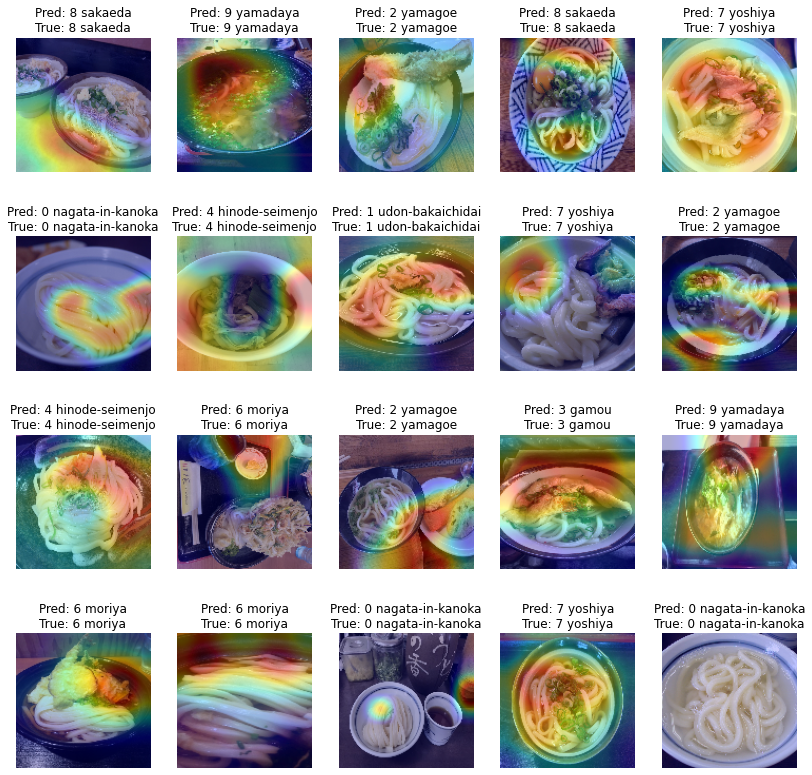

In [20]:
plt.figure(figsize=(14, 14))

for i in range(20):
    img = validX[i].astype("float32")    # validXからi番目の画像を選択
    true_index = validY[i]               # validYからi番目の値を選択

    input_tensor = np.expand_dims(img, axis=0)    # モデルに入力できるように画像データの次元を拡張
    pred = model.predict(input_tensor)[0]         # 推論
    pred_index = np.argmax(pred)                  # 推論結果から確率の最も高い店舗のindexを取得

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    # 色変換 BGR ---> RGB
    img = (255*img).astype("uint8")               # データ型変更 float ---> int

    # heatmapの生成
    heatmap = make_gradcam_heatmap(img_array=input_tensor,
                                model=model, 
                                last_conv_layer_name=last_conv_layer_name,
                                pred_index=pred_index)

    # heatmapの可視化
    heatmap = (255*heatmap).astype("uint8")                                  # データ型変更 float ---> int
    heatmap = cv2.resize(heatmap, img_size, interpolation = cv2.INTER_CUBIC) # リサイズ
    heatmap_jet = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)               # 色変換 grayscale ---> jet
    heatmap_jet = cv2.cvtColor(heatmap_jet, cv2.COLOR_BGR2RGB)               # 色変換 BGR ---> RGB

    alpha = 0.5                                                  # heatmapの強さ
    superimposed_img = img + alpha*heatmap_jet                   # 元画像とheatmapの合成
    superimposed_img = superimposed_img/superimposed_img.max()   # データの規格化(最小0.0, 最大1.0)

    plt.subplot(4, 5, i+1)
    text = f"Pred: {pred_index} {udonya_dict[pred_index]}\nTrue: {true_index} {udonya_dict[true_index]}"
    plt.title(text)               # 推論結果をタイトルとして表示
    plt.imshow(superimposed_img)  # 画像の表示
    plt.axis("off")